<a href="https://colab.research.google.com/github/GargiGoswami/BDSN_Project/blob/main/Gargi_Goswami_A21039_BDSN_ET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Logistic_Regression Model to predict Conversion Status of Customer with help of SPARK and Python**

In [1]:
! pip3 install pyspark

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('log_reg').getOrCreate()

In [3]:
# Load and Read the dataset
df=spark.read.csv('Data_Set.csv',inferSchema=True,header=True)

# Basic EDA :

To understand the data set and gather informations about the data

In [4]:
# Check the shape of the dataset
print((df.count(), len(df.columns)))

(20000, 6)


In [5]:
# Look at the dataset using SPARK
df.show(5)

+---------+---+--------------+--------+----------------+------+
|  Country|Age|Repeat_Visitor|Platform|Web_pages_viewed|Status|
+---------+---+--------------+--------+----------------+------+
|    India| 41|             1|   Yahoo|              21|     1|
|   Brazil| 28|             1|   Yahoo|               5|     0|
|   Brazil| 40|             0|  Google|               3|     0|
|Indonesia| 31|             1|    Bing|              15|     1|
| Malaysia| 32|             0|  Google|              15|     1|
+---------+---+--------------+--------+----------------+------+
only showing top 5 rows



In [6]:
# Chech the datatypes of the inputs
df.printSchema()

root
 |-- Country: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Repeat_Visitor: integer (nullable = true)
 |-- Platform: string (nullable = true)
 |-- Web_pages_viewed: integer (nullable = true)
 |-- Status: integer (nullable = true)



As  the columns of Country and Platform are categorical in nature so I have to convert it into numerical form.

In [7]:
# Check the statistical measures of the dataset
df.describe().show()

+-------+--------+-----------------+-----------------+--------+-----------------+------------------+
|summary| Country|              Age|   Repeat_Visitor|Platform| Web_pages_viewed|            Status|
+-------+--------+-----------------+-----------------+--------+-----------------+------------------+
|  count|   20000|            20000|            20000|   20000|            20000|             20000|
|   mean|    null|         28.53955|           0.5029|    null|           9.5533|               0.5|
| stddev|    null|7.888912950773227|0.500004090187782|    null|6.073903499824976|0.5000125004687693|
|    min|  Brazil|               17|                0|    Bing|                1|                 0|
|    max|Malaysia|              111|                1|   Yahoo|               29|                 1|
+-------+--------+-----------------+-----------------+--------+-----------------+------------------+



From the upper table I can see that the average age of visitors is close to 28 years, and they viewed around 9 web pages during the website visit.

In [8]:
# Check individual columns using group By function to understand the data in deeply.
df.groupBy('Country').count().show()

+---------+-----+
|  Country|count|
+---------+-----+
| Malaysia| 1218|
|    India| 4018|
|Indonesia|12178|
|   Brazil| 2586|
+---------+-----+



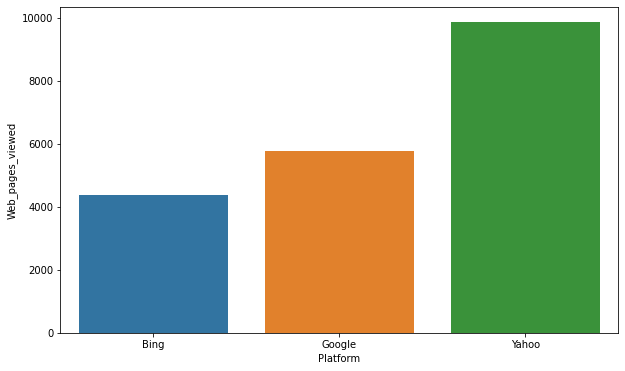

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
new_df = df.toPandas()
plt.figure(figsize=(10,6))
sns.barplot(y = new_df.groupby('Platform').count()['Web_pages_viewed'], x = new_df.reset_index().groupby('Platform').count()['Web_pages_viewed'].index)

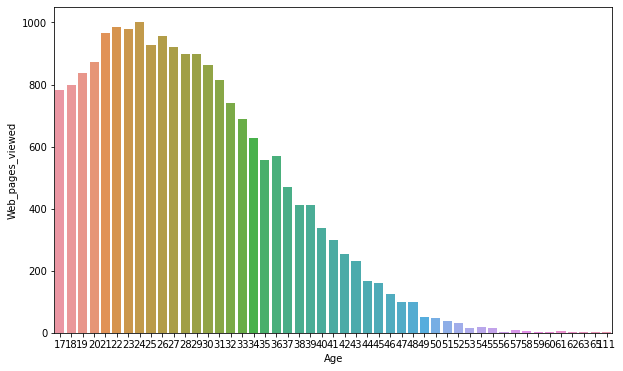

In [10]:
plt.figure(figsize=(10,6))
sns.barplot(y = new_df.groupby('Age').count()['Web_pages_viewed'], x = new_df.reset_index().groupby('Age').count()['Web_pages_viewed'].index)

So,the maximum number of visitors are from Indonesia.

In [11]:
df.groupBy('Platform').count().show()

+--------+-----+
|Platform|count|
+--------+-----+
|   Yahoo| 9859|
|    Bing| 4360|
|  Google| 5781|
+--------+-----+



The total numbers of Yahoo Platform users are the highest. 

In [12]:
df.groupBy('Status').count().show()

+------+-----+
|Status|count|
+------+-----+
|     1|10000|
|     0|10000|
+------+-----+



Here I have an equal number of users who are converted and non-converted.

In [13]:
 df.groupBy('Country').mean().show()

+---------+------------------+-------------------+---------------------+--------------------+
|  Country|          avg(Age)|avg(Repeat_Visitor)|avg(Web_pages_viewed)|         avg(Status)|
+---------+------------------+-------------------+---------------------+--------------------+
| Malaysia|27.792282430213465| 0.5730706075533661|   11.192118226600986|  0.6568144499178982|
|    India|27.976854156296664| 0.5433051269288203|   10.727227476356397|  0.6212045793927327|
|Indonesia| 28.43159796354081| 0.5207751683363442|    9.985711939563148|  0.5422893742814913|
|   Brazil|30.274168600154677|  0.322892498066512|    4.921113689095128|0.038669760247486466|
+---------+------------------+-------------------+---------------------+--------------------+



Here the average number of web_page_viewed is highest in Malaysia and lowest in Brazil.

In [14]:
df.groupBy('Platform').mean().show()

+--------+------------------+-------------------+---------------------+------------------+
|Platform|          avg(Age)|avg(Repeat_Visitor)|avg(Web_pages_viewed)|       avg(Status)|
+--------+------------------+-------------------+---------------------+------------------+
|   Yahoo|28.569226087838523| 0.5094837204584644|    9.599655137437875|0.5071508266558474|
|    Bing| 28.68394495412844| 0.4720183486238532|    9.114908256880733|0.4559633027522936|
|  Google|28.380038055699707| 0.5149628092025601|    9.804878048780488|0.5210171250648676|
+--------+------------------+-------------------+---------------------+------------------+



Here the average number of web_page_viewed is highest for Google Platform.

In [15]:
df.groupBy('Status').mean().show()

+------+--------+-------------------+---------------------+-----------+
|Status|avg(Age)|avg(Repeat_Visitor)|avg(Web_pages_viewed)|avg(Status)|
+------+--------+-------------------+---------------------+-----------+
|     1| 26.5435|             0.7019|              14.5617|        1.0|
|     0| 30.5356|             0.3039|               4.5449|        0.0|
+------+--------+-------------------+---------------------+-----------+



It is clearly seen that, there is a strong connection between the conversion 
status and the number of Web_pages_viewed along with repeat_Visitor.

# Feature Engineering :

Feature Engineering is essential to convert the categorical variables into numerical variables and create a single vector by combining all the input features with the help of Spark’s VectorAssembler

In [16]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler

In [17]:
Platform_indexer =StringIndexer(inputCol="Platform", outputCol="Platform_Num").fit(df)
df = Platform_indexer.transform(df)
df.show(4,False)

+---------+---+--------------+--------+----------------+------+------------+
|Country  |Age|Repeat_Visitor|Platform|Web_pages_viewed|Status|Platform_Num|
+---------+---+--------------+--------+----------------+------+------------+
|India    |41 |1             |Yahoo   |21              |1     |0.0         |
|Brazil   |28 |1             |Yahoo   |5               |0     |0.0         |
|Brazil   |40 |0             |Google  |3               |0     |1.0         |
|Indonesia|31 |1             |Bing    |15              |1     |2.0         |
+---------+---+--------------+--------+----------------+------+------------+
only showing top 4 rows



In [18]:
df.groupBy('Platform').count().orderBy('count', ascending=False).show(5,False)

+--------+-----+
|Platform|count|
+--------+-----+
|Yahoo   |9859 |
|Google  |5781 |
|Bing    |4360 |
+--------+-----+



In [19]:
df.groupBy('Platform_Num').count().orderBy('count', ascending=False).show(5,False)

+------------+-----+
|Platform_Num|count|
+------------+-----+
|0.0         |9859 |
|1.0         |5781 |
|2.0         |4360 |
+------------+-----+



In [20]:
# I have to represent each of these values into the form of a one hot encoded vector.
from pyspark.ml.feature import OneHotEncoder

In [21]:
Platform_encoder =OneHotEncoder(inputCol="Platform_Num", outputCol="Platforms_Vector")
Platform_encoder.setDropLast(False)
ohe = Platform_encoder.fit(df)
df = ohe.transform(df)

In [22]:
df.show(3,False)

+-------+---+--------------+--------+----------------+------+------------+----------------+
|Country|Age|Repeat_Visitor|Platform|Web_pages_viewed|Status|Platform_Num|Platforms_Vector|
+-------+---+--------------+--------+----------------+------+------------+----------------+
|India  |41 |1             |Yahoo   |21              |1     |0.0         |(3,[0],[1.0])   |
|Brazil |28 |1             |Yahoo   |5               |0     |0.0         |(3,[0],[1.0])   |
|Brazil |40 |0             |Google  |3               |0     |1.0         |(3,[1],[1.0])   |
+-------+---+--------------+--------+----------------+------+------------+----------------+
only showing top 3 rows



In [23]:
df.groupBy('Platforms_Vector').count().orderBy('count', ascending=False).show(5,False)

+----------------+-----+
|Platforms_Vector|count|
+----------------+-----+
|(3,[0],[1.0])   |9859 |
|(3,[1],[1.0])   |5781 |
|(3,[2],[1.0])   |4360 |
+----------------+-----+



The final feature which is used for building Logistic Regression is Platforms_Vector.

In [24]:
Country_indexer = StringIndexer(inputCol="Country", outputCol="Country_Num").fit(df)

In [25]:
df = Country_indexer.transform(df)

In [26]:
df.groupBy('Country').count().orderBy('count', ascending = False).show(5,False)

+---------+-----+
|Country  |count|
+---------+-----+
|Indonesia|12178|
|India    |4018 |
|Brazil   |2586 |
|Malaysia |1218 |
+---------+-----+



In [27]:
df.groupBy('Country_Num').count().orderBy('count', ascending = False).show(5,False)

+-----------+-----+
|Country_Num|count|
+-----------+-----+
|0.0        |12178|
|1.0        |4018 |
|2.0        |2586 |
|3.0        |1218 |
+-----------+-----+



In [28]:
Country_encoder =OneHotEncoder(inputCol="Country_Num", outputCol="Country_Vector")
Country_encoder.setDropLast(False)
ohhe = Country_encoder.fit(df)
df = ohhe.transform(df)

In [29]:
df.select(['Country','Country_Num','Country_Vector']).show(3,False)

+-------+-----------+--------------+
|Country|Country_Num|Country_Vector|
+-------+-----------+--------------+
|India  |1.0        |(4,[1],[1.0]) |
|Brazil |2.0        |(4,[2],[1.0]) |
|Brazil |2.0        |(4,[2],[1.0]) |
+-------+-----------+--------------+
only showing top 3 rows



In [30]:
df.groupBy('Country_Vector').count().orderBy('count', ascending = False).show(5,False)

+--------------+-----+
|Country_Vector|count|
+--------------+-----+
|(4,[0],[1.0]) |12178|
|(4,[1],[1.0]) |4018 |
|(4,[2],[1.0]) |2586 |
|(4,[3],[1.0]) |1218 |
+--------------+-----+



In this way I have converted both the categorical columns into numerical forms

In [31]:
# Now it is needed to assemble all of the input columns into a single vector that would act as the input feature for the Logistic Regression model.
df_assembler = VectorAssembler(inputCols=['Platforms_Vector','Country_Vector','Age', 'Repeat_Visitor', 
'Web_pages_viewed'], outputCol="features")

In [32]:
df = df_assembler.transform(df)

In [33]:
df.printSchema()

root
 |-- Country: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Repeat_Visitor: integer (nullable = true)
 |-- Platform: string (nullable = true)
 |-- Web_pages_viewed: integer (nullable = true)
 |-- Status: integer (nullable = true)
 |-- Platform_Num: double (nullable = false)
 |-- Platforms_Vector: vector (nullable = true)
 |-- Country_Num: double (nullable = false)
 |-- Country_Vector: vector (nullable = true)
 |-- features: vector (nullable = true)



Now I have one extra column named features, which is nothing but a combination of all the input features represented as a Single Dense Vector.

In [34]:
df.select(['features','Status']).show(10,False)

+----------------------------------------+------+
|features                                |Status|
+----------------------------------------+------+
|(10,[0,4,7,8,9],[1.0,1.0,41.0,1.0,21.0])|1     |
|(10,[0,5,7,8,9],[1.0,1.0,28.0,1.0,5.0]) |0     |
|(10,[1,5,7,9],[1.0,1.0,40.0,3.0])       |0     |
|(10,[2,3,7,8,9],[1.0,1.0,31.0,1.0,15.0])|1     |
|(10,[1,6,7,9],[1.0,1.0,32.0,15.0])      |1     |
|(10,[1,5,7,9],[1.0,1.0,32.0,3.0])       |0     |
|(10,[1,5,7,9],[1.0,1.0,32.0,6.0])       |0     |
|(10,[1,3,7,9],[1.0,1.0,27.0,9.0])       |0     |
|(10,[0,3,7,9],[1.0,1.0,32.0,2.0])       |0     |
|(10,[2,3,7,8,9],[1.0,1.0,31.0,1.0,16.0])|1     |
+----------------------------------------+------+
only showing top 10 rows



In [35]:
# Now select only features column as input and the Status column as output for training the logistic regression model.
model_df=df.select(['features','Status'])

# Splitting the Dataset :

Split the dataset into a training and test dataset in order to train and evaluate the performance of the logistic regression model. I split it in a 75/25 ratio and train our model on 75% of the dataset.

In [36]:
training_df,test_df=model_df.randomSplit([0.75,0.25])

In [37]:
print(training_df.count())

14954


In [38]:
training_df.groupBy('Status').count().show()

+------+-----+
|Status|count|
+------+-----+
|     1| 7495|
|     0| 7459|
+------+-----+



This ensures we have a balance set of the target class (Status) into the 
training and test set.

In [39]:
print(test_df.count())

5046


In [40]:
test_df.groupBy('Status').count().show()

+------+-----+
|Status|count|
+------+-----+
|     1| 2505|
|     0| 2541|
+------+-----+



# Build and Train Logistic Regression Model:

I build and train the logistic regression model using features as the input column and status as the output column.

In [41]:
from pyspark.ml.classification import LogisticRegression

In [42]:
log_reg=LogisticRegression(labelCol='Status').fit(training_df)

# Training Results:

I can now access the predictions made by the model using the evaluate function in SPARK that executes all the steps in an optimized way. It gives another Dataframe that contains four columns in total, including prediction and probability.

In [43]:
train_results=log_reg.evaluate(training_df).predictions

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


In [44]:
train_results.filter(train_results['Status']==1).filter(train_results['prediction']==1).select(['Status','prediction','probability']).show(10,False)

+------+----------+-----------------------------------------+
|Status|prediction|probability                              |
+------+----------+-----------------------------------------+
|1     |1.0       |[0.3979982999404371,0.6020017000595629]  |
|1     |1.0       |[0.23596047581233015,0.7640395241876698] |
|1     |1.0       |[0.23596047581233015,0.7640395241876698] |
|1     |1.0       |[0.06313638167183974,0.9368636183281602] |
|1     |1.0       |[0.06313638167183974,0.9368636183281602] |
|1     |1.0       |[0.06313638167183974,0.9368636183281602] |
|1     |1.0       |[0.06313638167183974,0.9368636183281602] |
|1     |1.0       |[0.030519835009161785,0.9694801649908382]|
|1     |1.0       |[0.030519835009161785,0.9694801649908382]|
|1     |1.0       |[0.030519835009161785,0.9694801649908382]|
+------+----------+-----------------------------------------+
only showing top 10 rows



# Evaluate Logistic Regression Model on Test Data

Now check the performance of the 
model on test data. So the evaluate function is used, to make predictions on the test data.

In [45]:
results=log_reg.evaluate(test_df).predictions

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


In [46]:
results.printSchema()

root
 |-- features: vector (nullable = true)
 |-- Status: integer (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [47]:
results.select(['Status','prediction']).show(10,False)

+------+----------+
|Status|prediction|
+------+----------+
|0     |0.0       |
|0     |0.0       |
|0     |0.0       |
|1     |0.0       |
|1     |1.0       |
|1     |1.0       |
|1     |1.0       |
|1     |1.0       |
|1     |1.0       |
|1     |1.0       |
+------+----------+
only showing top 10 rows



# Confusion Matrix:

As this is a classification problem, I use a confusion matrix to 
gauge the performance of the model.

In [48]:
tp = results[(results.Status == 1) & (results.prediction == 1)].count()
tn = results[(results.Status == 0) & (results.prediction == 0)].count()
fp = results[(results.Status == 0) & (results.prediction == 1)].count()
fn = results[(results.Status == 1) & (results.prediction == 0)].count()

# Accuracy:

It is the most basic metric for evaluating any classifier.

In [49]:
accuracy=float((tp+tn) /(results.count()))

In [50]:
print(accuracy)

0.9365834324217202


# Recall:

Recall rate shows how much of the positive class cases we are able to predict correctly out of the total positive class observations.

In [51]:
recall = float(tp)/(tp + fn)

In [52]:
print(recall)

0.9365269461077844


# Precision:

Precision rate talks about the number of true positives predicted correctly out of all the predicted positives observations.

In [53]:
precision = float(tp) / (tp + fp)

In [54]:
print(precision)

0.9357798165137615


# Conclusion:

So, the recall rate and precision rate are also in the same range, which 
is due to the fact that our target class was well balanced. It means my model is good to predict Conversion Status.